## Variable Selection

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# select item (use item 2 if it switched model numbers but is same item)
item = '4100'
item2 = None

month = 10

store_count_change = 0 # percentage increase in store count
growth_rate = 1 + (store_count_change / 100) # converts to a percentage

# this changes the length dropped off for the benchmarks
forecast_length = 4

# this changes the array in the pycaret if you do the arange it will do a point forecast at the future time
#forecast_lenth_array = np.arange(forecast_length, forecast_length+1)
forecast_lenth_array = forecast_length
print("Growth Rate:", growth_rate)

Growth Rate: 1.0


## Data

In [199]:
df = pd.read_csv('Items Shipped by Item by Month.csv')

In [200]:
df.head()

,Date,Item,Item Description,Product Group,Parent Product Group,Quantity,Amount
0,2024-Oct,8003,E-Series 22in Electric Tabletop Griddle w/Cart...,E-Griddles,Cooking Unit,120.0,17404.80
1,2024-Oct,1868,"36"" Griddle AirFryer",Griddles,Cooking Unit,72.0,21793.16
2,2024-Oct,1785,"28"" AirFryer Combo",Griddles,Cooking Unit,42.0,9032.56
3,2024-Oct,2379,Tabletop Pizza Oven-Walmart 2024,Pizza Oven,Cooking Unit,1404.0,122360.56
4,2024-Oct,2379,Tabletop Pizza Oven-Walmart 2024,Pizza Oven,Cooking Unit,3544.0,308864.56


## Data Formatting

In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33926 entries, 0 to 33925
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  33926 non-null  object 
 1   Item                  33926 non-null  object 
 2   Item Description      33775 non-null  object 
 3   Product Group         33667 non-null  object 
 4   Parent Product Group  33926 non-null  object 
 5   Quantity              33910 non-null  float64
 6   Amount                33926 non-null  float64
dtypes: float64(2), object(5)
memory usage: 1.8+ MB


In [202]:
df['Date'] = pd.to_datetime(df['Date'])

if item2:
    df_item = df[(df['Item'] == item) | (df['Item'] == item2)]
else:
    df_item = df[df['Item'] == item]

df_item = df_item.groupby(['Date'])['Quantity'].sum().reset_index().sort_values(by=['Date'], ascending=True)

df_item = df_item.resample('M', on='Date').sum().reset_index()

last_month = datetime.strptime(df_item['Date'].astype(str).iloc[-1], '%Y-%m-%d')
month_number = last_month.month
month_number

if month_number < month:
    df_item = df_item
else:
    df_item = df_item[:-1] # drop the last month if in start or middle of month

df_item.tail(1)

,Date,Quantity
56,2024-09-30,8034.0


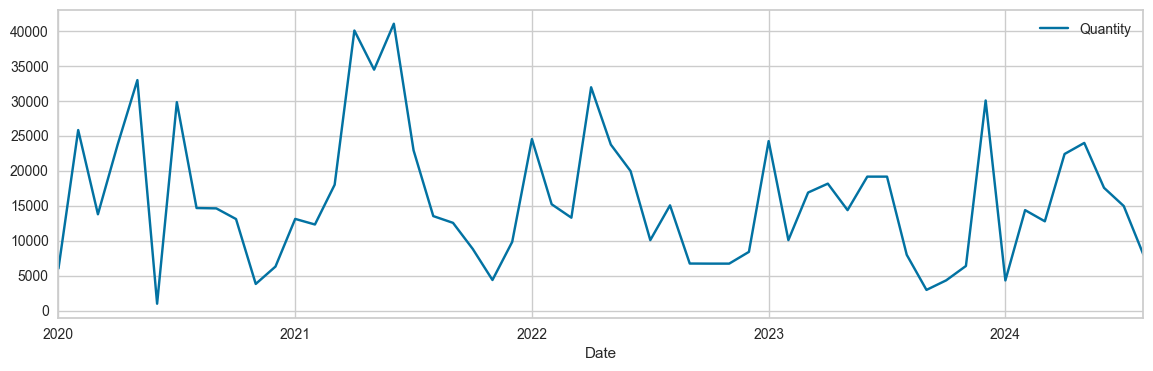

In [148]:
# Plot the time series data
df_item.plot(x='Date', y='Quantity', figsize=(14,4))
unchanged_df = df_item.copy() # saving a copy of the data set to then plot forecasts with original data

## Data Transformation

### Box Cox Transformation

In [149]:
from scipy.stats import boxcox

        Date  Quantity  boxcox_units
0 2020-01-31    6030.0     94.484269
1 2020-02-29   25806.0    178.000056
2 2020-03-31   13776.0    135.532403
3 2020-04-30   23736.0    171.663395
4 2020-05-31   32946.0    197.864243
The optimal lambda for Box-Cox transformation is: 0.42779793141093253


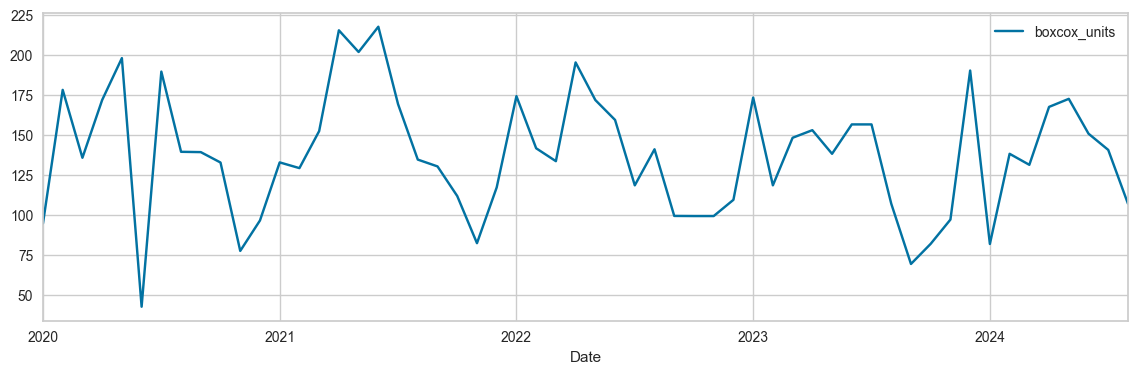

In [150]:
# Apply Box-Cox transformation to find the optimal lambda
try:
    df_item['boxcox_units'] , optimal_lambda = boxcox(df_item.Quantity)
except ValueError: 
    df_item['Quantity'] = df_item['Quantity'] + 1
    df_item['boxcox_units'] , optimal_lambda = boxcox(df_item.Quantity)

print(df_item.head())
box_cox_df = df_item.copy()

# Plot the transformed data with optimal lambda
df_item.plot(x='Date', y='boxcox_units', figsize=(14,4))

# Print the optimal lambda
print(f'The optimal lambda for Box-Cox transformation is: {optimal_lambda}')

### ACF and PACF

In [151]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

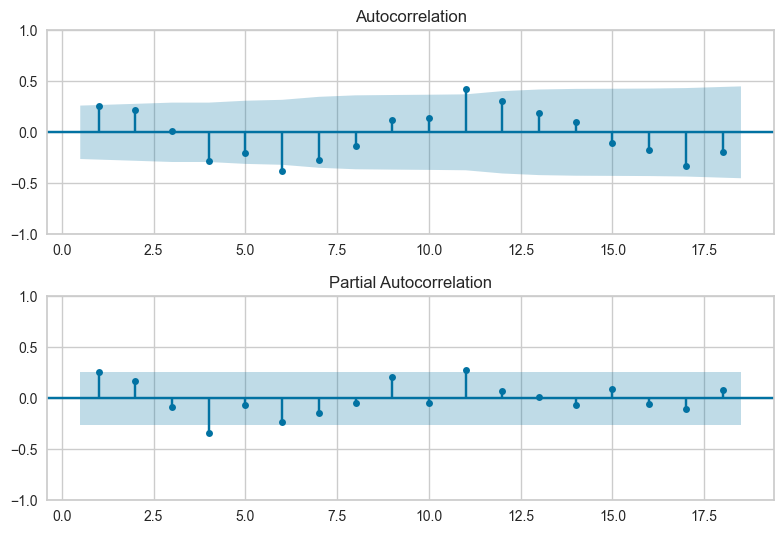

In [152]:
# Plot ACF and PACF for the original airline passenger data
plt.figure()
plt.subplot(211)
plot_acf(df_item['Quantity'], ax=plt.gca(), zero=False)
plt.subplot(212)
plot_pacf(df_item['Quantity'], ax=plt.gca(), zero=False)
plt.tight_layout()
plt.show()

### Stationarity

In [153]:
from statsmodels.tsa.stattools import adfuller

Augmented Dickey-Fuller Test: Box-Cox Data
ADF Test Statistic            -5.945664e+00
p-value                        2.207353e-07
# Lags Used                    0.000000e+00
Number of Observations Used    5.500000e+01
Critical Value (1%)           -3.555273e+00
Critical Value (5%)           -2.915731e+00
Critical Value (10%)          -2.595670e+00
=> The series is stationary.


<Axes: xlabel='Date'>

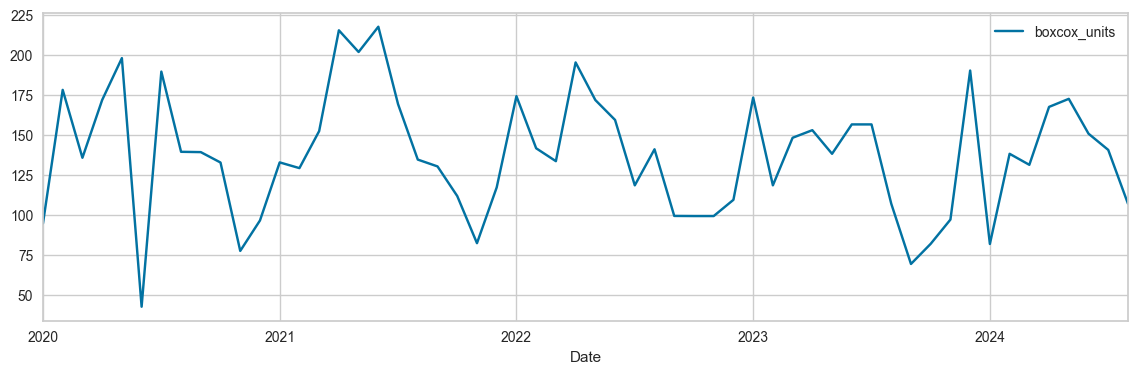

In [154]:
# Function to perform ADF test
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("=> The series is stationary.")
    else:
        print("=> The series is non-stationary.")
    return result[1]

# Apply the ADF test to the transformed data
p_value = adf_test(df_item['boxcox_units'], title='Box-Cox Data')

df_item.plot(x='Date',y='boxcox_units', figsize=(14,4))

#### Differencing Data

Augmented Dickey-Fuller Test: boxcox quantity- Differenced
ADF Test Statistic            -5.908030e+00
p-value                        2.679662e-07
# Lags Used                    9.000000e+00
Number of Observations Used    4.500000e+01
Critical Value (1%)           -3.584829e+00
Critical Value (5%)           -2.928299e+00
Critical Value (10%)          -2.602344e+00
=> The series is stationary.


<Axes: xlabel='Date'>

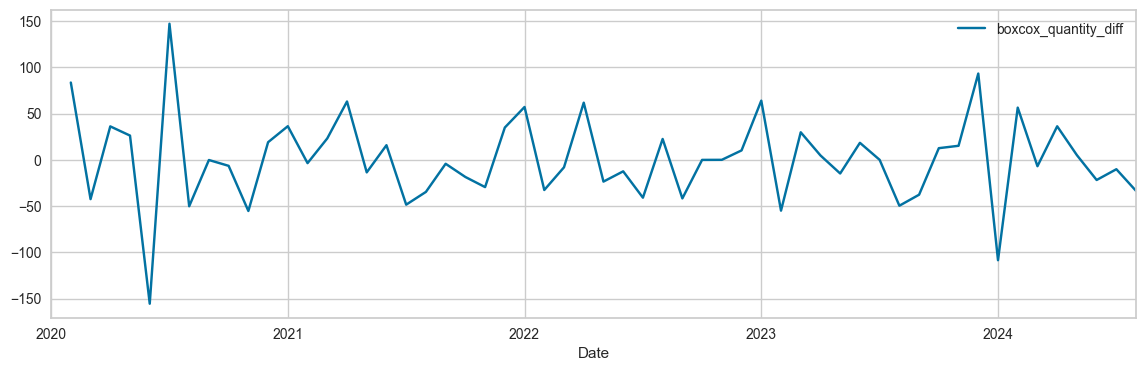

In [155]:
# differencing the data
df_item['boxcox_quantity_diff'] = df_item['boxcox_units'].diff()

# Perform ADF test on differenced data
adf_test(df_item['boxcox_quantity_diff'].dropna(), title='boxcox quantity- Differenced')

# Plot the differenced data
df_item.plot(x='Date', y='boxcox_quantity_diff', figsize=(14,4))

In [156]:
df_item = df_item.set_index('Date')

# if stationary use boxcox_units if not stationary use boxcox_quantity_diff
if p_value < 0.05:
    target = 'boxcox_units'
    drop_column = 'boxcox_quantity_diff'
else:
    target = 'boxcox_quantity_diff'
    drop_column = 'boxcox_units'

df_item = df_item.drop(columns=[drop_column,'Quantity'])

df_item.tail()

,boxcox_units
Date,
2024-04-30,167.358707
2024-05-31,172.395171
2024-06-30,150.601291
2024-07-31,140.449570
2024-08-31,106.814042


## Benchmarking

#### Train and Test Data

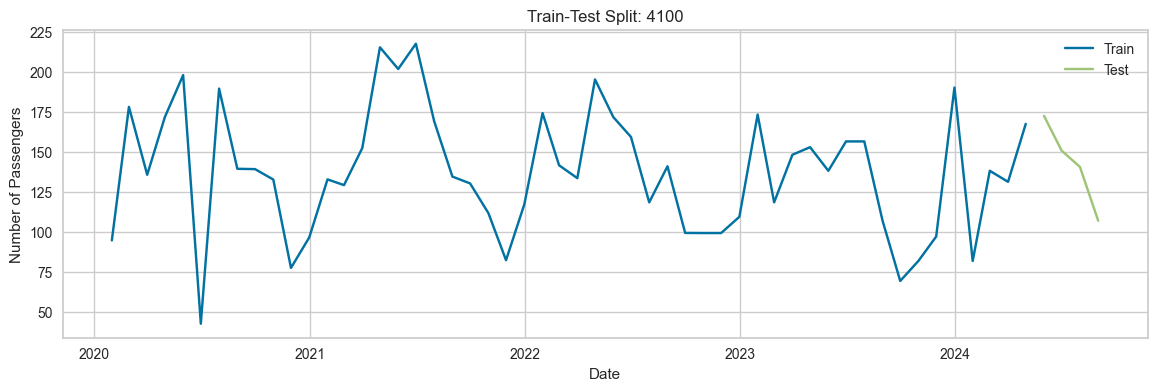

In [157]:
# Split the data
train = df_item[[target]][:-forecast_length]
test = df_item[[target]][-forecast_length:]

# Visualize the train and test data
plt.figure(figsize=(14, 4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.title(f'Train-Test Split: {item}')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

### Function to generate benchmarks

In [158]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create forecasts using different methods
def forecast_methods(train, test, season_length=12):
    y_hat = test.copy()
    
    # Naive Forecast
    y_hat['naive'] = train.iloc[-1][target]
    
    # Seasonal Naive Forecast
    y_hat['snaive'] = np.tile(train[target].values[-season_length:], len(test) // season_length + 1)[:len(test)]
    
    # Mean Forecast
    y_hat['mean'] = train[target].mean()
    
    # Drift Forecast
    drift = (train[target].iloc[-1] - train[target].iloc[0]) / (len(train) - 1)
    y_hat['drift'] = train[target].iloc[-1] + (np.arange(1, len(test) + 1) * drift)
    
    # One Step Ahead Naive Forecast
    y_hat['naive_one_step'] = test[target].shift(1)
    
    return y_hat

### Functions to Calculate Forecast Accuracy Metrics

In [159]:
# RMSE, sMAPE, MASE, RMSSE, MAE, MAPE, R2 calculation functions
def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mase(y_true, y_pred, train):
    mae_naive = np.mean(np.abs(train[target].diff().dropna()))
    return np.mean(np.abs(y_true - y_pred)) / mae_naive

def rmsse(y_true, y_pred, train):
    mse_naive = np.mean(train[target].diff().dropna() ** 2)
    return np.sqrt(mean_squared_error(y_true, y_pred) / mse_naive)

def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

Naive Forecast - MASE: 0.75, RMSSE: 0.69, MAE: 27.31, RMSE: 34.26, MAPE: 22.47%, sMAPE: 18.79%, R2: -1.10
Snaive Forecast - MASE: 0.38, RMSSE: 0.39, MAE: 14.03, RMSE: 19.17, MAPE: 8.79%, sMAPE: 9.17%, R2: 0.34
Mean Forecast - MASE: 0.56, RMSSE: 0.49, MAE: 20.57, RMSE: 24.26, MAPE: 15.03%, sMAPE: 14.83%, R2: -0.05
Drift Forecast - MASE: 0.83, RMSSE: 0.76, MAE: 30.17, RMSE: 37.95, MAPE: 24.84%, sMAPE: 20.42%, R2: -1.58
Best Benchmark Method: Snaive with RMSE: 19.17


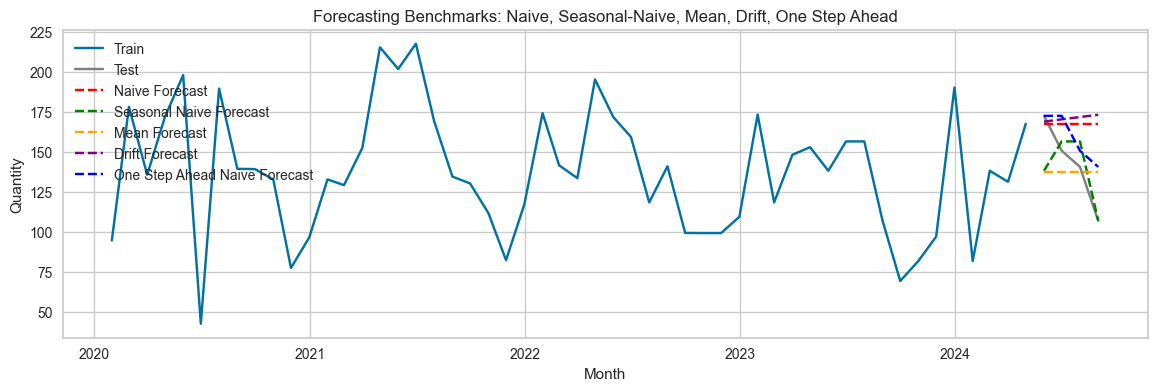

In [160]:
# Generate forecasts
y_hat = forecast_methods(train, test)

# Calculate and display forecasting scores
actual = test[target]

# Drop NaN values in 'naive_one_step'
y_hat['naive_one_step'] = y_hat['naive_one_step'].fillna(method='bfill')

forecast_scores = {}
for method in ['naive', 'snaive', 'mean', 'drift']:
    mase_value = mase(actual, y_hat[method], train)
    rmsse_value = rmsse(actual, y_hat[method], train)
    mae = mean_absolute_error(actual, y_hat[method])
    rmse = np.sqrt(mean_squared_error(actual, y_hat[method]))
    mape_value = mape(actual, y_hat[method])
    smape_value = smape(actual, y_hat[method])
    r2 = r2_score(actual, y_hat[method])
    
    forecast_scores[method] = {
        'MASE': mase_value,
        'RMSSE': rmsse_value,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape_value,
        'sMAPE': smape_value,
        'R2': r2
    }
    print(f"{method.capitalize()} Forecast - MASE: {mase_value:.2f}, RMSSE: {rmsse_value:.2f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape_value:.2f}%, sMAPE: {smape_value:.2f}%, R2: {r2:.2f}")

# Find the best forecast method based on RMSE (can change to other metrics if needed)
best_method = min(forecast_scores, key=lambda x: forecast_scores[x]['RMSE'])
best_benchmark = y_hat[best_method]
print(f"Best Benchmark Method: {best_method.capitalize()} with RMSE: {forecast_scores[best_method]['RMSE']:.2f}")

# Predict into the future using the best benchmark
future_periods = forecast_length  # Define how many future periods to predict
future_index = pd.date_range(start=test.index[-1] + pd.DateOffset(months=1), periods=future_periods, freq='M')
future_forecast = pd.Series(index=future_index, dtype=float)

if best_method == 'naive':
    future_forecast[:] = train.iloc[-1][target]
elif best_method == 'snaive':
    future_forecast[:] = np.tile(train[target].values[-forecast_length:], len(future_forecast) // forecast_length + 1)[:len(future_forecast)]
elif best_method == 'mean':
    future_forecast[:] = train[target].mean()
elif best_method == 'drift':
    drift = (train[target].iloc[-1] - train[target].iloc[0]) / (len(train) - 1)
    future_forecast[:] = train[target].iloc[-1] + (np.arange(1, len(future_forecast) + 1) * drift)
# elif best_method == 'naive_one_step':
#     future_forecast[:] = test[target].iloc[-1]

# Visualization
plt.figure(figsize=(14, 4))
plt.plot(train.index, train[target], label='Train')
plt.plot(test.index, test[target], label='Test', color='grey')
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast', color='red', linestyle='--')
plt.plot(y_hat.index, y_hat['snaive'], label='Seasonal Naive Forecast', color='green', linestyle='--')
plt.plot(y_hat.index, y_hat['mean'], label='Mean Forecast', color='orange', linestyle='--')
plt.plot(y_hat.index, y_hat['drift'], label='Drift Forecast', color='purple', linestyle='--')
plt.plot(y_hat.index, y_hat['naive_one_step'], label='One Step Ahead Naive Forecast', color='blue', linestyle='--')

plt.title('Forecasting Benchmarks: Naive, Seasonal-Naive, Mean, Drift, One Step Ahead')
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.legend(loc='upper left')
plt.show()

I've plotted the one step ahead forecast but it isn't in the comparison of the best benchmark because i'm not doing a one step ahead forecast in pycaret. 

In [161]:
future_forecast

2024-09-30     81.611104
2024-10-31    138.019790
2024-11-30    131.122777
2024-12-31    167.358707
Freq: M, dtype: float64

## Pycaret Forecast

In [162]:
from pycaret.time_series import *

In [163]:
df_item.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56 entries, 2020-01-31 to 2024-08-31
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   boxcox_units  56 non-null     float64
dtypes: float64(1)
memory usage: 896.0 bytes


#### Setting up experiment

In [164]:
exp = TSForecastingExperiment()
exp.setup(data=df_item, 
          target=target,
          numeric_imputation_target='ffill',
          fh=forecast_lenth_array)

,Description,Value
0,session_id,643
1,Target,boxcox_units
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(56, 1)"
5,Transformed data shape,"(56, 1)"
6,Transformed train set shape,"(52, 1)"
7,Transformed test set shape,"(4, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


### Checking Set Up

In [165]:
exp.plot_model(plot='train_test_split')

In [166]:
#### Check cross-validation setup  ----
exp.plot_model(plot="cv")

### Comparing Models

In [167]:
best = exp.compare_models(sort='rmse', turbo=False)
comparison_results = exp.pull()
best_model_name = comparison_results.iloc[0]['Model']
mean_rmse_compare = comparison_results.iloc[0]['RMSE']

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
snaive,Seasonal Naive Forecaster,0.7751,0.5785,21.4011,23.3471,0.1911,0.1785,0.2493,2.0300
arima,ARIMA,0.7810,0.5897,21.5776,23.8115,0.1917,0.1809,0.1995,1.9567
stlf,STLF,0.8916,0.6829,24.7001,27.7178,0.1947,0.1967,-0.2564,0.0767
catboost_cds_dt,CatBoost Regressor w/ Cond. Deseasonalize & Detrending,1.0219,0.7753,28.1120,31.0459,0.2557,0.2254,-0.0335,1.4600
theta,Theta Forecaster,1.0264,0.7744,28.2686,31.0751,0.2590,0.2297,-0.0599,0.0667
auto_arima,Auto ARIMA,0.9843,0.7791,27.0658,31.2206,0.2696,0.2246,0.0671,2.7967
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.0139,0.8305,27.8931,33.2745,0.2414,0.2206,-0.1434,0.1667
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,1.0514,0.8574,28.8759,34.3147,0.2649,0.2319,-0.2139,0.1833
exp_smooth,Exponential Smoothing,1.1131,0.8657,30.6531,34.7426,0.2799,0.2470,-0.3905,0.1033
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,1.0993,0.8715,30.2421,34.8967,0.2714,0.2401,-0.2547,0.2700


#### Tune Model

In [168]:
try:
    # Tune the model
    tuned = exp.tune_model(best, optimize='RMSE', n_iter=50, choose_better=True)
    # Retrieve the tuning results
    tuned_results = exp.pull()
    # Extract the mean RMSE from the results
    mean_rmse = tuned_results.loc['Mean', 'RMSE']
except ValueError:
    print("Could Not Tune")


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2023-04,0.7202,0.5555,20.6282,23.4631,0.1421,0.1498,-0.3412
1,2023-08,0.6919,0.5005,19.1473,20.2343,0.2156,0.1903,0.8192
2,2023-12,0.9132,0.6797,24.4279,26.3439,0.2157,0.1955,0.2698
Mean,NaT,0.7751,0.5785,21.4011,23.3471,0.1911,0.1785,0.2493
SD,NaT,0.0983,0.0750,2.2240,2.4956,0.0347,0.0204,0.4740


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.4s finished


#### Finalizing Model

In [169]:
try:
    final = exp.finalize_model(tuned)
except NameError:
    final = exp.finalize_model(best)

In [170]:
exp.plot_model(final)

In [171]:
unseen_predictions = exp.predict_model(final)
#unseen_predictions = exp.predict_model(final, fh=forecast_lenth_array, X=prediction_df)
unseen_predictions

,y_pred
2024-09,81.7108
2024-10,96.8763
2024-11,190.0989
2024-12,81.6111


## Reversing Transformation

In [172]:
from scipy.special import inv_boxcox

last_original_value = box_cox_df['boxcox_units'].iloc[-1]

# Reverse differencing (undo stationarity) if we applied it
if p_value < 0.05:
    reversed_diff_predictions = unseen_predictions
    reversed_diff_benchmark = future_forecast
else:
    reversed_diff_predictions = unseen_predictions.cumsum() + last_original_value
    reversed_diff_benchmark = future_forecast.cumsum() + last_original_value

# lambda value for Box-Cox transformation
boxcox_lambda = optimal_lambda

# Reverse Box-Cox transformation
original_scale_predictions = inv_boxcox(reversed_diff_predictions, boxcox_lambda)
original_scale_benchmark = inv_boxcox(reversed_diff_benchmark, boxcox_lambda)
original_scale_predictions['y_pred'] = original_scale_predictions['y_pred'] * growth_rate

In [173]:
# making it so we can plot the forecast
unchanged_df.index = unchanged_df['Date']
unchanged_df = unchanged_df.drop(columns = ['Date'])

### Visualizing Prediction

,y_pred,Benchmark Values
Month,,
2024-09,"4,332","4,320"
2024-10,"6,384","14,364"
2024-11,"30,036","12,768"
2024-12,"4,320","22,386"


Snaive with RMSE: 19.17
Best Tuned model: Seasonal Naive Forecaster with RMSE 23.35


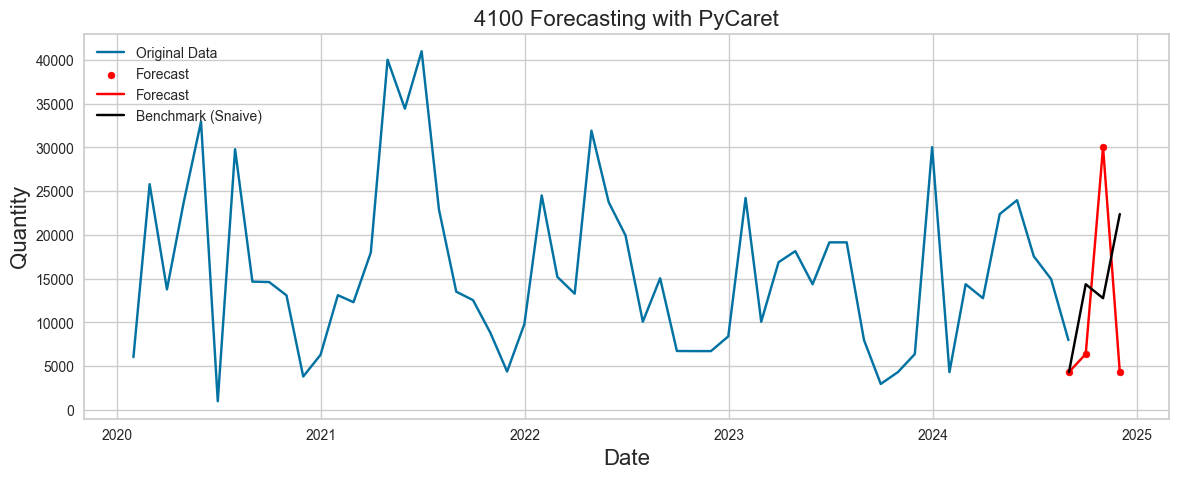

In [174]:
# Ensure the index is a DatetimeIndex before converting it to PeriodIndex
if isinstance(original_scale_predictions.index, pd.PeriodIndex):
    original_scale_predictions.index = original_scale_predictions.index.to_timestamp()

if isinstance(original_scale_benchmark.index, pd.PeriodIndex):
    original_scale_benchmark.index = original_scale_benchmark.index.to_timestamp()

# Convert the index to show only "YYYY-MM"
original_scale_predictions.index = original_scale_predictions.index.to_period('M').strftime('%Y-%m')
original_scale_benchmark.index = original_scale_benchmark.index.to_period('M').strftime('%Y-%m')

# Rename the Series
original_scale_predictions.name = 'Predicted Values'
original_scale_benchmark.name = 'Benchmark Values'

# Display both side by side, after ensuring indexes match
merged_df = pd.concat([original_scale_predictions, original_scale_benchmark], axis=1)
merged_df.index.name = 'Month'  # Optionally, rename the index for clarity
merged_df = merged_df.round(0).applymap(lambda x: f"{int(x):,}" if pd.notnull(x) else '')
# Display the formatted DataFrame
display(merged_df)


# Print RMSE and model information
print(f"{best_method.capitalize()} with RMSE: {forecast_scores[best_method]['RMSE']:.2f}")
try:
    print(f"Best Tuned model: {best_model_name} with RMSE {mean_rmse:.2f}")
except NameError:
    print(f"Best Untuned model: {best_model_name} with Mean RMSE: {mean_rmse_compare:.2f}")

# Plotting forecast with original data
plt.figure(figsize=(14, 5))
plt.plot(unchanged_df.index, unchanged_df['Quantity'], label='Original Data')
plt.scatter(pd.to_datetime(original_scale_predictions.index), original_scale_predictions, color='red', label='Forecast', s=25)
plt.plot(pd.to_datetime(original_scale_predictions.index), original_scale_predictions, color='red', label='Forecast')
plt.plot(pd.to_datetime(original_scale_benchmark.index), original_scale_benchmark, label=f'Benchmark ({best_method.capitalize()})', color='black', linestyle='-')
plt.title(f'{item} Forecasting with PyCaret', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Quantity', fontsize=16)
plt.legend(loc='upper left')
plt.show()